In [ ]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import PIL
import matplotlib.pyplot as plt

In [2]:
IMAGE_SHAPE = (250, 250)
batch_size = 30
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_d = 'train'
training_image_data = image_generator.flow_from_directory(train_d, target_size=IMAGE_SHAPE)

test_d = 'test'
testing_image_data = image_generator.flow_from_directory(test_d, target_size=IMAGE_SHAPE)


Found 1156 images belonging to 9 classes.
Found 502 images belonging to 9 classes.


In [3]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_d,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_d,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.
Found 502 files belonging to 9 classes.


['Ajwa', 'Galaxy', 'Mejdool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


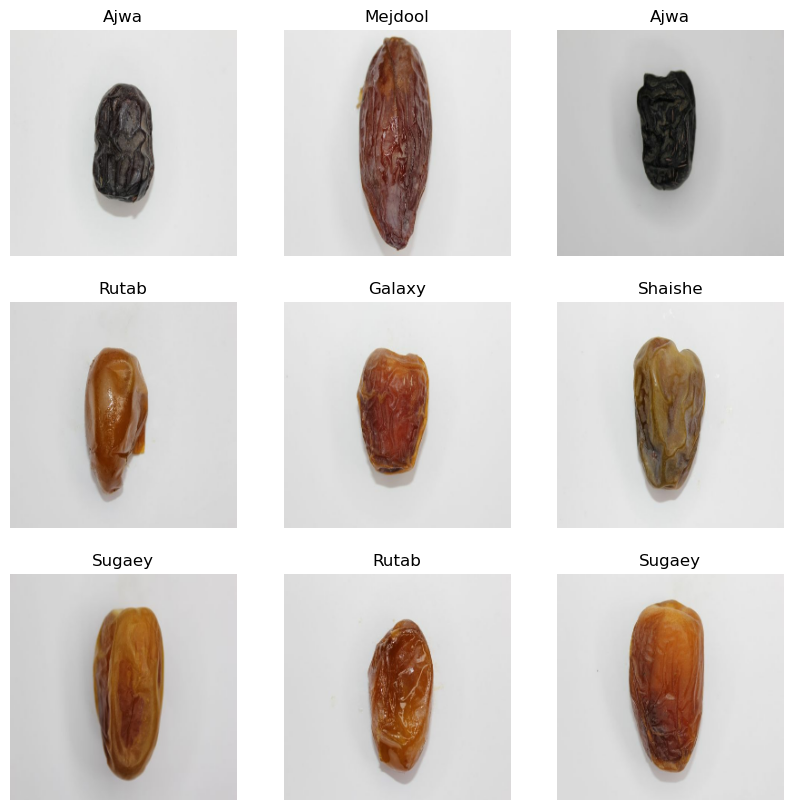

In [4]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE

In [5]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]


In [6]:

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])



model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1

In [7]:

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
39/39 [==============================] - 90s 2s/step - loss: 2.3057 - accuracy: 0.2301 - val_loss: 1.7216 - val_accuracy: 0.3068
Epoch 2/15
39/39 [==============================] - 90s 2s/step - loss: 1.1994 - accuracy: 0.5744 - val_loss: 1.0768 - val_accuracy: 0.5777
Epoch 3/15
39/39 [==============================] - 88s 2s/step - loss: 0.7453 - accuracy: 0.7396 - val_loss: 0.5591 - val_accuracy: 0.8147
Epoch 4/15
39/39 [==============================] - 89s 2s/step - loss: 0.5189 - accuracy: 0.8304 - val_loss: 0.9799 - val_accuracy: 0.6494
Epoch 5/15
39/39 [==============================] - 88s 2s/step - loss: 0.4857 - accuracy: 0.8339 - val_loss: 0.4847 - val_accuracy: 0.8287
Epoch 6/15
39/39 [==============================] - 91s 2s/step - loss: 0.3933 - accuracy: 0.8685 - val_loss: 0.4243 - val_accuracy: 0.8586
Epoch 7/15
39/39 [==============================] - 90s 2s/step - loss: 0.3103 - accuracy: 0.9048 - val_loss: 0.3877 - val_accuracy: 0.8645
Epoch 8/15
39/39 [==

In [8]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

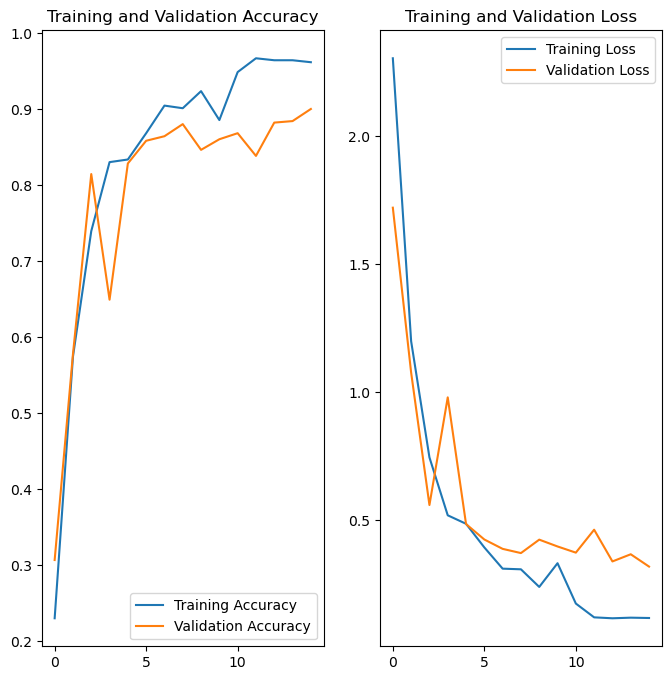

In [9]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [10]:
test_images, test_labels = [], []
for images, labels in test_ds:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

In [11]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [12]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

16/16 [==============================] - 7s 395ms/step


In [13]:
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))

print("Confusion Matrix:")
cm = confusion_matrix(test_labels, predicted_labels)
print(cm)


Classification Report:
              precision    recall  f1-score   support

        Ajwa       1.00      1.00      1.00        53
      Galaxy       0.93      0.88      0.90        57
     Mejdool       0.95      0.88      0.91        41
     Meneifi       0.84      0.84      0.84        70
   NabtatAli       0.90      0.85      0.88        54
       Rutab       0.88      0.82      0.85        44
     Shaishe       0.93      1.00      0.96        52
      Sokari       0.95      0.90      0.92        80
      Sugaey       0.76      0.94      0.84        51

    accuracy                           0.90       502
   macro avg       0.90      0.90      0.90       502
weighted avg       0.90      0.90      0.90       502

Confusion Matrix:
[[53  0  0  0  0  0  0  0  0]
 [ 0 50  0  4  0  0  1  1  1]
 [ 0  0 36  3  0  0  0  0  2]
 [ 0  1  0 59  0  5  2  1  2]
 [ 0  0  1  0 46  0  0  2  5]
 [ 0  0  0  2  1 36  0  0  5]
 [ 0  0  0  0  0  0 52  0  0]
 [ 0  3  0  2  2  0  1 72  0]
 [ 0  0  1  0 

In [14]:
accuracy = np.sum(test_labels == predicted_labels) / len(test_labels)
print("Accuracy:", accuracy)

Accuracy: 0.900398406374502


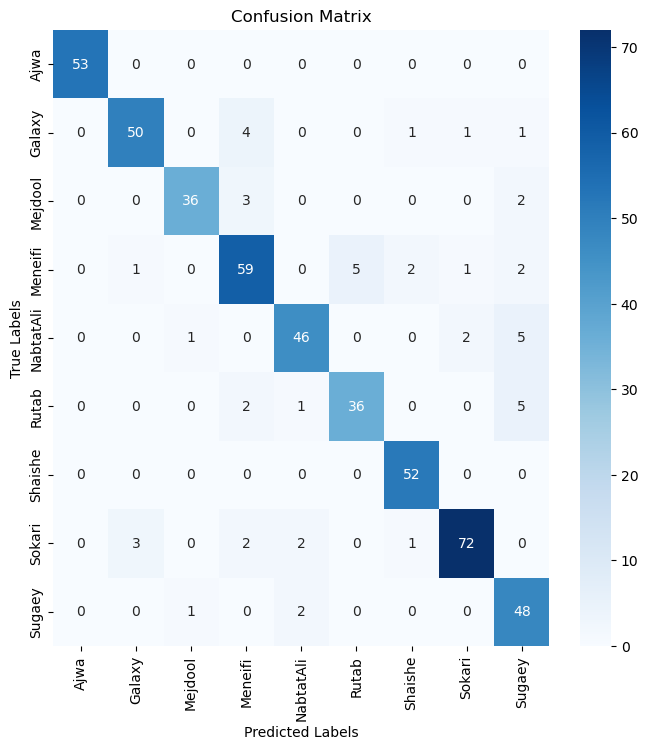

In [15]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

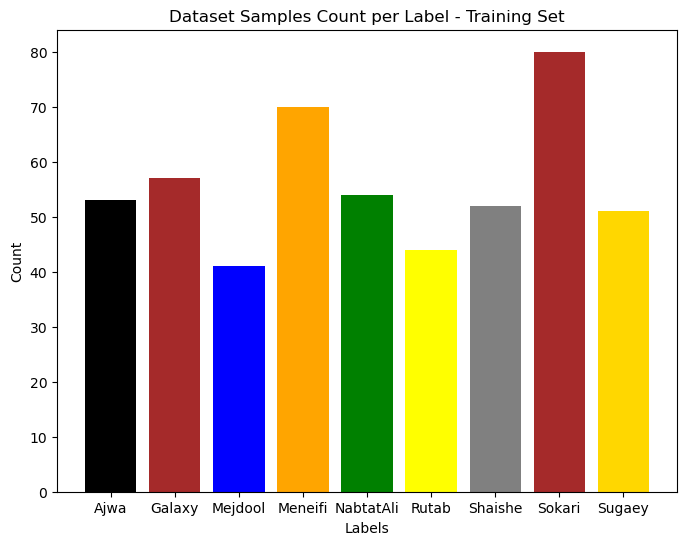

In [16]:
c = ['black', 'brown', 'blue', 'orange', 'green', 'yellow', 'grey', 'brown', 'gold']

plt.figure(figsize=(8, 6))
train_labels_count = [len(np.where(test_labels == i)[0]) for i in range(num_classes)]
plt.bar(class_names, train_labels_count, color = c)
plt.title("Dataset Samples Count per Label - Training Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

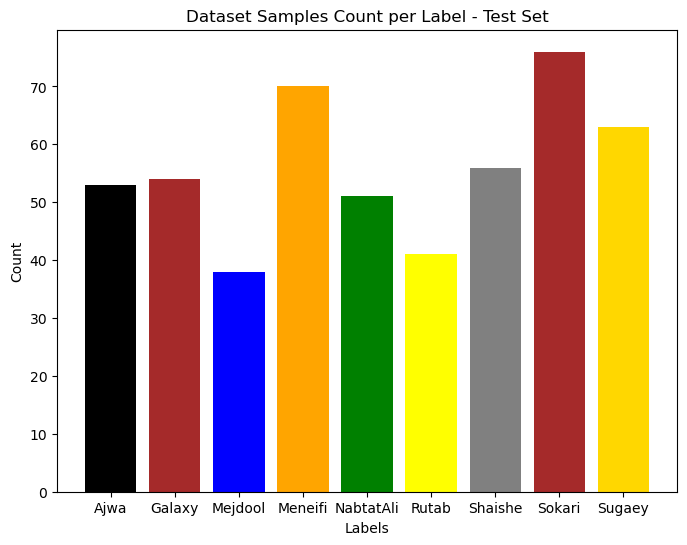

In [17]:
plt.figure(figsize=(8, 6))
test_labels_count = [len(np.where(predicted_labels == i)[0]) for i in range(num_classes)]
plt.bar(class_names, test_labels_count, color = c)
plt.title("Dataset Samples Count per Label - Test Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()